In [40]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm

import statsmodels.tsa.api as smt

from pandas.tseries.offsets import BDay

import pandas as pd
import numpy as np
import scipy

In [42]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = ''  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_BullishCollarBW
ES_BearishCollarBW
ES_CallSpread
ES_PutSpread
ES_ContFut
ZS_BullishCollarBW
ZS_BearishCollarBW
ZS_CallSpread
ZS_PutSpread
ZS_ContFut
CL_BullishCollarBW
CL_BearishCollarBW
CL_CallSpread
CL_PutSpread
CL_ContFut
ZW_BullishCollarBW
ZW_BearishCollarBW
ZW_CallSpread
ZW_PutSpread
ZW_ContFut
ZN_BullishCollarBW
ZN_BearishCollarBW
ZN_CallSpread
ZN_PutSpread
ZN_ContFut
NG_BullishCollarBW
NG_BearishCollarBW
NG_CallSpread
NG_PutSpread
NG_ContFut
ZC_BullishCollarBW
ZC_BearishCollarBW
ZC_CallSpread
ZC_PutSpread
ZC_ContFut
CL_SMART_Ichimoku_Long
ES_SMART_Ichimoku_Long
NG_SMART_Ichimoku_Long
ZC_SMART_Ichimoku_Long
ZS_SMART_Ichimoku_Long
ZW_SMART_Ichimoku_Long
ZN_SMART_Ichimoku_Long
CL_SMART_Ichimoku_VerticalSpread_Bullish
CL_SMART_Ichimoku_Straddle_Bullish
ES_SMART_Ichimoku_Straddle_Bullish
NG_SMART_Ichimoku_Straddle_Bullish
ZC_SMART_Ichimoku_Straddle_Bullish
ZS_SMART_Ichimoku_Straddle_Bullish
ZW_SMART_Ichimoku_Straddle_Bullish
ZN_SMART_Ichimoku_Straddle_Bullish


In [43]:
class Strategy_ARIMA_Model(StrategyBase):
    name = 'Strategy_ARIMA_Model'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
   
    def calc_entryexit_rules(self, forecast_period, ar_p, i_d, ma_q, rules_index):
        i = 1
        px_ser = self.data.exo
        empty_ser = pd.Series(False, index=px_ser.dropna().index)
        signals_df = pd.DataFrame()
        
        
        ts = (px_ser - px_ser.shift(1)).dropna()
        #ts = px_ser.ewm(50).mean().dropna()
        
        signals_df['entry_rule'] = empty_ser
        signals_df['exit_rule'] = empty_ser
        
        while True:
            forecast_period = forecast_period

            try:
                model = smt.ARIMA(ts.iloc[:i], order=(ar_p,i_d,ma_q)).fit()

            except Exception:
                i += forecast_period
                continue


            forecast_daterange = pd.date_range(start=ts.iloc[:i].index[-1] + BDay(1), periods=forecast_period)
            #forecast_daterange = pd.date_range(start=ts.iloc[:i].index[-1] + pd.DateOffset(1), freq='B')

            # Handling missing dates
            if (forecast_daterange.isin(px_ser.dropna().index).all() == False) & (forecast_daterange[-1] < ts.index[-1]):
                i += forecast_period
                continue

            # If daterange is out of TSeries index, break while loop
            if forecast_daterange[-1] > ts.index[-1]:
                break

            forecast_values = model.forecast(forecast_period)

            forecast_series = pd.Series(forecast_values[0], index=forecast_daterange)

            if rules_index == 0:
                signals_df['entry_rule'].ix[ts.iloc[:i].index[-1]: 
                                                   forecast_series.index[-1]] = forecast_series[0] > forecast_series[-1]

                if (signals_df['entry_rule'].ix[forecast_series.index[-1]] == True):
                    signals_df['exit_rule'].ix[forecast_series.index[-1] + BDay(1)] = True


            if rules_index == 1:
                signals_df['entry_rule'].ix[ts.iloc[:i].index[-1]: 
                                                   forecast_series.index[-1]] = forecast_series[0] < forecast_series[-1]

                if (signals_df['entry_rule'].ix[forecast_series.index[-1]] == True):
                    signals_df['exit_rule'].ix[forecast_series.index[-1] + BDay(1)] = True

            i += forecast_period
        
        return signals_df.entry_rule, signals_df.exit_rule
    
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            direction, forecast_period, ar_p, i_d, ma_q, rules_index = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            direction, forecast_period, ar_p, i_d, ma_q, rules_index = params

        # Defining EXO price
        px = self.data.exo
                
        entry_rule, exit_rule = self.calc_entryexit_rules(forecast_period, ar_p, i_d, ma_q, rules_index)

        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

## Script settings

In [44]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': Strategy_ARIMA_Model,
        'exo_name': 'ZN_PutSpread',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,          
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [-1]),
                        #OptParam('Pct rank value', 9, 0, 1, 0.2),
                        OptParam('Forecast period', 1, 2, 30, 2),
                        OptParamArray('AR p', [1]),
                        OptParamArray('I d', [1]),
                        OptParamArray('MA q', [0]),
                        #OptParam('Rolling_period', 9, 30, 30, 10),
                        OptParamArray('Rules index', np.arange(2)),
                        
            ],
    },
    'swarm': {
        'members_count': 2,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [45]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

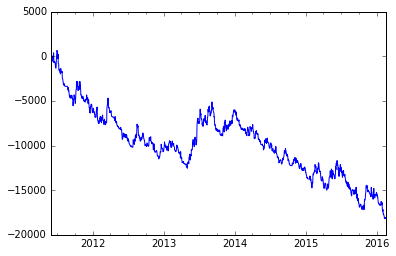

In [46]:
smgr.strategy.data.exo.plot()

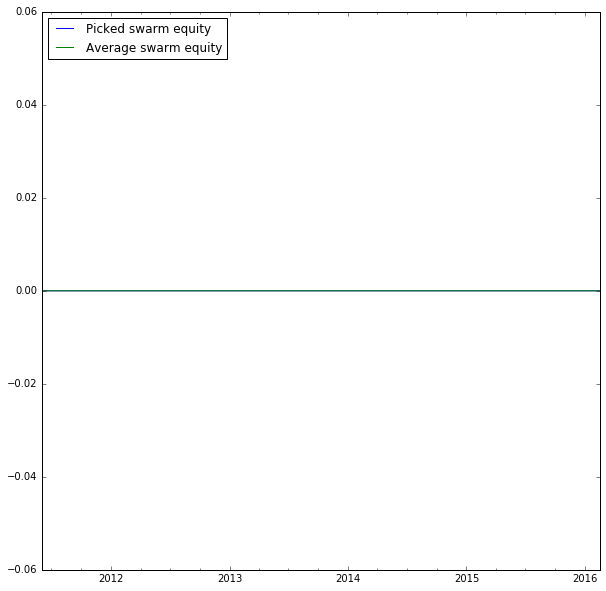

In [47]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

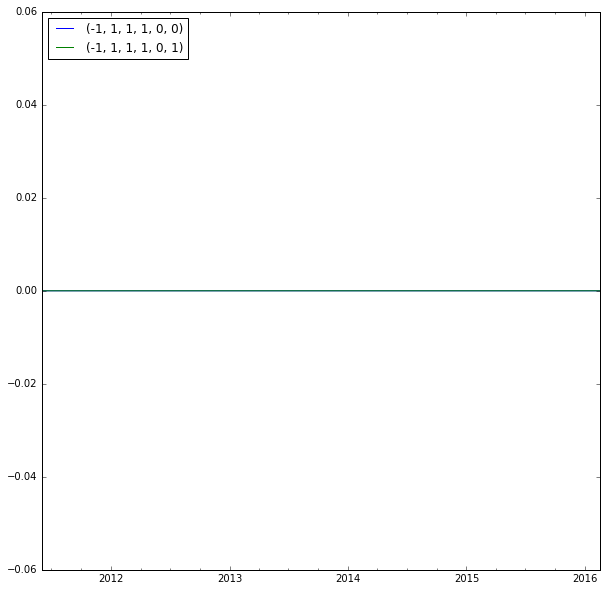

In [48]:
smgr.raw_swarm.plot(legend=True)
legend(loc=2);

In [ ]:
smgr.picked_swarm.plot()

smgr.picked_swarm.sum(1).plot(label='smgr.picked_swarm-sum')
smgr.picked_equity.plot(label='Picked swarm equity')

# Swarm exposure

In [ ]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [ ]:
smgr.picked_stats

## Exo information

In [ ]:
smgr.strategy.exoinfo.exo_info

In [ ]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

In [ ]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

In [ ]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [ ]:
smgr.save('./swarms/')

In [ ]:
smgr.raw_swarm#.plot()